In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import collections
import operator

from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import svm 
from sklearn import tree
from sklearn import neural_network
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier



# import random
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold

In [2]:
### Helper Functions

def Accuracy(Y_true, Y_prob):
    """
    Prediction accuracy
    """
    #return accuracy_score(Y_true, np.argmax(Y_prob, axis=1))
    return accuracy_score(Y_true, Y_prob)

def Preprocess(X):
    print("preprocessing...")
    # Mean subtraction to centre the data
    X_mean = np.mean(X, axis = 0)
    X = X - X_mean
    # Standardization
    X /= np.std(X, axis = 0)
    return X

def Predict(model, X):
    p = model.predict(X)
    return p

def Visualize(X, Y):
    plt.scatter(X[:,0], X[:,1],c=Y)
    plt.show()
       
red_patch = mpatches.Patch(color='r', label='Failed')
grn_patch = mpatches.Patch(color='g', label='Successful')

In [3]:
### Load Dataset

# Full Data
xdf = pd.read_csv('ks-projects-201801.csv')
x = xdf.values
# Sample of data
xsdf = pd.read_csv('sampledata.csv')
xs = xsdf.values

In [4]:
### Get Indices into a dictionary
i = 0
index = {}
for label in xdf.axes[1]:
    index[label] = i
    i += 1

In [5]:
### Remove Invalid States from Dataset
row_to_delete = []
for i in range(x.shape[0]):
    s = x[i,index['state']]
    if s == 'canceled' or s == 'undefined' or s == 'suspended' or s == 'live':
        row_to_delete.append(i)
    elif x[i,index['usd_goal_real']] > 10000:
        row_to_delete.append(i)
        
x = np.delete(x,row_to_delete, 0)
del row_to_delete

In [6]:
### Counter Frequencies of Categories

freq = []
for i in range(x.shape[1]):
    freq.append(collections.Counter(x[:,i]))

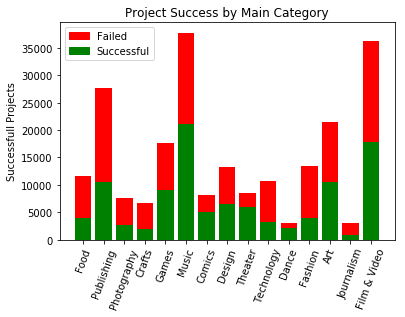

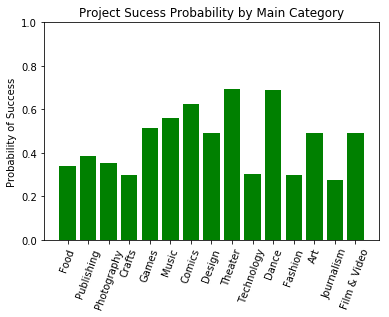

In [7]:
### Project Succes by Category

freqs = {}
freqf = {}
for i in range(x.shape[0]):
    key = x[i,index['main_category']]
    if (key not in freqs):
        freqs[key] = 0
    if (key not in freqf):
        freqf[key] = 0
    if x[i,index['state']] == 'successful':
        freqs[key] += 1
    else:
        freqf[key] += 1
        
cats = plt.bar(range(len(freqs)), list(freqs.values()), align='center', color='g')
catf = plt.bar(range(len(freqf)), list(freqf.values()), align='center', color='r', bottom=list(freqs.values()))
plt.xticks(range(len(freqs)), list(freqs.keys()))
plt.xticks(rotation=70)
plt.legend(handles=[red_patch, grn_patch])
plt.ylabel('Successfull Projects')
plt.title('Project Success by Main Category')
plt.show()  

for key in freqs:
    freqs[key] /= freq[index['main_category']][key]
    
#sorted_categories = sorted(freqs.items(), key=operator.itemgetter(1))

pCat = plt.bar(range(len(freqs)), list(freqs.values()), align='center', color='g')
plt.xticks(range(len(freqs)), list(freqs.keys()))
plt.xticks(rotation=70)
plt.ylabel('Probability of Success')
plt.title('Project Sucess Probability by Main Category')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

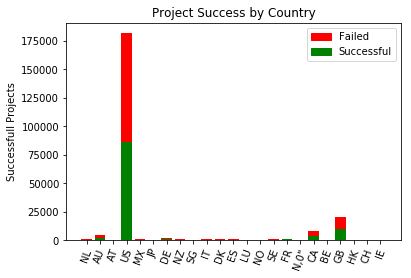

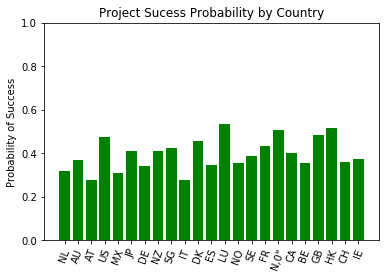

In [8]:
### Project Success by Country

freqs = {}
freqf = {}
for i in range(x.shape[0]):
    key = x[i,index['country']]
    if (key not in freqs):
        freqs[key] = 0
    if (key not in freqf):
        freqf[key] = 0
    if x[i,index['state']] == 'successful':
        freqs[key] += 1
    else:
        freqf[key] += 1

cats = plt.bar(range(len(freqs)), list(freqs.values()), align='center', color='g')
catf = plt.bar(range(len(freqf)), list(freqf.values()), align='center', color='r', bottom=list(freqs.values()))
plt.xticks(range(len(freqs)), list(freqs.keys()))
plt.xticks(rotation=70)
plt.ylabel('Successfull Projects')
plt.title('Project Success by Country')
plt.legend(handles=[red_patch, grn_patch]) 
axes = plt.gca()
plt.show()  

for key in freqs:
    freqs[key] /= freq[index['country']][key]

pCat = plt.bar(range(len(freqs)), list(freqs.values()), align='center', color='g')
plt.xticks(range(len(freqs)), list(freqs.keys()))
plt.xticks(rotation=70)
plt.ylabel('Probability of Success')
plt.title('Project Sucess Probability by Country')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

In [9]:
### Enumerate Text Based Columns
x_enum = x[:,:]
columns_to_enumerate = [2,3,4,9,11]
for col in columns_to_enumerate:
    b = list(set(x_enum[:,col]))
    x_enum[:,col] = [b.index(i) for i in x_enum[:,col]]
    
### Mulitdimension One Hot encoding
onehot_encoder = preprocessing.OneHotEncoder()
main_cat = onehot_encoder.fit_transform(x[:,index['main_category']].reshape(len(x[:,index['main_category']]),1)).toarray()
country =  onehot_encoder.fit_transform(x[:,index['country']].reshape(len(x[:,index['country']]),1)).toarray()


for i in range(len(x[:,0])):
    x[i,index['main_category']] = 1 << x[i,index['main_category']]
    x[i,index['country']] = 1 << x[i,index['country']]

In [10]:
### Determine the time duration

times = np.empty([x.shape[0]], dtype=datetime)

for i in range(x.shape[0]):
    deadline = datetime.strptime(x[i,5] , '%Y-%m-%d')
    launched = datetime.strptime(x[i,7] , '%Y-%m-%d %X')
    times[i] = (deadline - launched).total_seconds()/3600/24
    
times = times.reshape(len(times), 1)


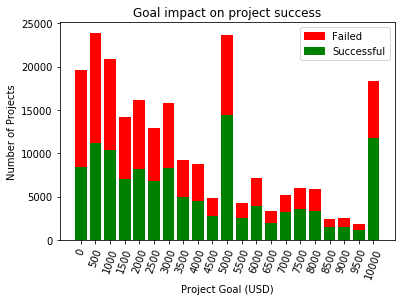

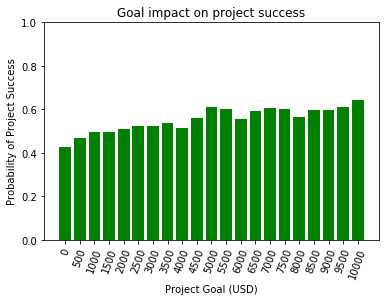

In [11]:
### Project success by goal value
hist1, bins1 = np.histogram(x[:,index['usd_goal_real']], bins=np.linspace(0, 10500, num=22))

def getBin(val):
    return int(val/500)

freqs = np.zeros(len(hist1))
freqf = np.zeros(len(hist1))

for i in range(len(x[:,index['usd_goal_real']])):
    key = getBin(x[i,index['usd_goal_real']])
    if key >= len(freqs):
        continue
    if x[i,index['state']] == 1:
        freqs[key] += 1
    else:
        freqf[key] += 1

goals = plt.bar(bins1[:-1], freqs, align='center', color='g', width=400)
goalf = plt.bar(bins1[:-1], freqf, align='center', color='r', bottom=freqs, width=400)
plt.xticks(bins1[:-1])
plt.xticks(rotation=70)
plt.ylabel('Number of Projects')
plt.xlabel('Project Goal (USD)')
plt.title('Goal impact on project success')
plt.legend(handles=[red_patch, grn_patch])
axes = plt.gca()
plt.show()  


for i in range(len(freqs)):
    freqs[i] /= hist1[i]

pGoal = plt.bar(bins1[:-1], freqs, align='center', color='g', width=400)
plt.xticks(bins1[:-1])
plt.xticks(rotation=70)
plt.ylabel('Probability of Project Success')
plt.xlabel('Project Goal (USD)')
plt.title('Goal impact on project success')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

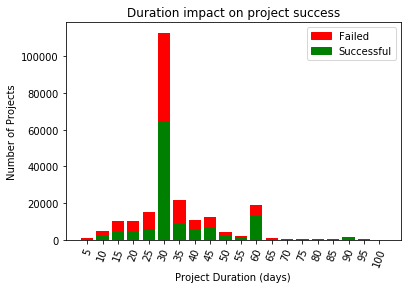

/Users/mvanheukelom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


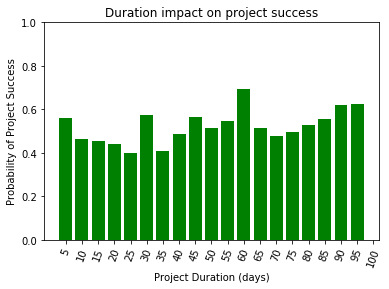

In [12]:
### Project success by time duration

hist, bins = np.histogram(times[:], bins=np.linspace(0, 100, num=21))

def getBin(time):
    return int(time/5)

freqs = np.zeros(len(hist))
freqf = np.zeros(len(hist))

for i in range(len(times)):
    key = getBin(times[i])
    if key >= len(freqs):
        continue
    if x[i,index['state']] == 1:
        freqs[key] += 1
    else:
        freqf[key] += 1

cats = plt.bar(bins[1:], freqs, align='center', color='g', width=4)
catf = plt.bar(bins[1:], freqf, align='center', color='r', bottom=freqs, width=4)
plt.xticks(bins[1:])
plt.xticks(rotation=70)
plt.ylabel('Number of Projects')
plt.xlabel('Project Duration (days)')
plt.title('Duration impact on project success')
plt.legend(handles=[red_patch, grn_patch])
axes = plt.gca()
plt.show()  

for i in range(len(freqs)):
    freqs[i] /= hist[i]

pCat = plt.bar(bins[1:], freqs, align='center', color='g', width=4)
plt.xticks(bins[1:])
plt.xticks(rotation=70)
plt.ylabel('Probability of Project Success')
plt.xlabel('Project Duration (days)')
plt.title('Duration impact on project success')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

In [13]:
### Create Classifier Input
input_cols = [index['usd_goal_real']]

sz = len(input_cols) + main_cat.shape[1] + 1

X = np.zeros((x.shape[0], sz))
X[:,:len(input_cols)] = x[:,input_cols]
X[:,len(input_cols):-1] = main_cat
X[:,-1:] = times


In [14]:
### Create Data Output
Y = np.array(x[:, index['state']]).tolist()


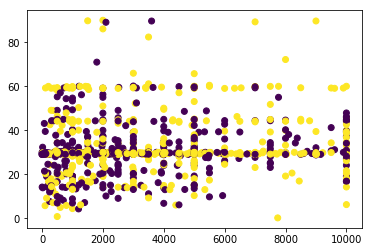

In [15]:
### Preprocess
Visualize(X[:1000, [0,-1]], Y[:1000])

##X = Preprocess(X)

In [16]:
### Train Test Split
tsz = 100
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X[:tsz], Y[:tsz], test_size=0.2, random_state=1)

print(Xtrain.shape)
print(Xtest.shape)

(80, 17)
(20, 17)


In [ ]:
### Create Classifier
def Classify(X,Y, ensemble=False, C=1.0):
    #clf = tree.DecisionTreeClassifier(random_state=0)
    #clf = svm.SVC(C = C, probability=True, kernel='poly', verbose=True, degree=3)
    clf = linear_model.LogisticRegression(solver='sag', n_jobs=-1)
    #clf = neural_network.MLPClassifier(hidden_layer_sizes=(5), early_stopping=False, verbose=True, activation="relu")
    if not ensemble:
        clf.fit(X,Y)
        return clf
    model = BaggingClassifier(base_estimator=clf, n_jobs=-1)
    model.fit(X,Y)
    return model


clf = Classify(Xtrain, Ytrain, False)

In [93]:
Ypred = clf.predict(Xtest)

print(str(sum(Ypred)) + '/' + str(len(Ypred)))

print( Accuracy(Ytest[:], Ypred[:]) )
print(Ytest[:10])
print(Ypred[:10])

8/20
0.65
[1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
[0 1 1 1 0 0 0 0 1 0]
